In [1]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
source_name='NGC 2110'
ra=88.047400
dec=-7.456247
scw_list='scws_NGC2110_isgri_10deg.txt' # choice among available scw lists
host='analyse-staging-1.2.reproducible.online' #choice between 'https://www.astro.unige.ch/cdci/astrooda' and 'analyse-staging-1.2.reproducible.online' 
if host=='analyse-staging-1.2.reproducible.online':
    try:
        token=raw_input() # token for restricted access server
    except:
        token=input() # token for restricted access server
else:
    token=''
rebin=5 # minimal significance in energy bin, for spectral plotting

-


In [3]:
name=source_name.replace(" ", "")

In [26]:
cookies=dict(_oauth2_proxy=token)
disp=DispatcherAPI(host=host+'/dispatch-data',instrument='mock',cookies=cookies,protocol='https')

In [5]:
f = open(scw_list, 'r')
scws=[]
for line in f:
    line = line.strip()
    columns = line.split()
    scws.append(columns[0])
f.close()
m=int(len(scws)/50.)
print(m)
scw_lists=[]
for i in range(m):
    count=0
    j=0    
    scw_string=''
    while(count<50):
        scw_string=scw_string+str(scws[50*i+count])+','
        count=count+1
    scw_lists.append(scw_string[:-1])

24


In [6]:
data=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      scw_list=scw_lists[0],
                      E1_keV=20.0,
                      E2_keV=40.0,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=5.0,
                      product_type='Real')

waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data


query done succesfully!


In [7]:
data.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,unicode10,float64,float64,float64,int64,int64,int64,float64
3,Ark 120,9.78393650055,79.0356903076,-0.127120032907,-32768,2,0,0.000280000007479
4,H 0614+091,20.3825931549,94.2858428955,9.14374637604,-32768,2,0,0.000280000007479
14,NGC 2110,16.466463089,88.0670318604,-7.46830034256,-32768,2,0,0.000280000007479


In [8]:
api_cat=data.dispatcher_catalog_1.get_api_dictionary()

In [9]:
spectrum_results=[]
for i in range(len(scw_lists)):
    print(i)
    data=disp.get_product(instrument='isgri',
                            product='isgri_spectrum',
                            scw_list=scw_lists[i],
                            query_type='Real',
                            osa_version='OSA10.2',
                            RA=ra,
                            DEC=dec,
                            detection_threshold=5.0,
                            radius=15.,
                            product_type='Real',
                            selected_catalog=api_cat)
    spectrum_results.append(data)

0
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data


query done succesfully!
1
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data


query done succesfully!
2
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data


query done succesfully!
3
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data


query done succesfully!
4
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data


query done succesfully!
5
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data


query done succesfully!
6
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data


query done succe

In [10]:
for ID,s in enumerate(data._p_list):
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)

(0, 1, 2)


In [11]:
d=spectrum_results[0]
spec=d._p_list[ID_spec].data_unit[1].data
arf=d._p_list[ID_arf].data_unit[1].data
rmf=d._p_list[ID_rmf].data_unit[2].data
ch=spec['CHANNEL']
rate=spec['RATE']*0.
err=spec['STAT_ERR']*0.
syst=spec['SYS_ERR']*0.
rate.fill(0)
err.fill(0)
syst.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos=0.
corr_expos=np.zeros(len(rate))
for k in range(len(scw_lists)):
    d=spectrum_results[k]
    spec=d._p_list[0].data_unit[1].data
    arf=d._p_list[1].data_unit[1].data
    rmf=d._p_list[2].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos=tot_expos+expos
    for j in range(len(rate)):
        if(spec['QUALITY'][j]==0):          
            rate[j]=rate[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err[j]=err[j]+1./(spec['STAT_ERR'][j])**2
            syst[j]=syst[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos[j]=corr_expos[j]+expos

    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos


rate=rate/err
err=1/sqrt(err)
matrix=matrix/tot_expos
specresp=specresp/tot_expos
syst=sqrt(syst/(corr_expos+1))



/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in divide
/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in divide


In [12]:
specname=name+'_spectrum.fits'
arfname=name+'_arf.fits.gz'
rmfname=name+'_rmf.fits.gz'
!cp spectrum.fits $specname
!cp arf.fits.gz $arfname
!cp rmf.fits.gz $rmfname

hdul = fits.open(name+'_spectrum.fits', mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', tot_expos)
spec=hdul[1].data
spec['RATE']=rate
spec['SYS_ERR']=syst
spec['STAT_ERR']=err
hdul.flush()
hdul.close()
hdul = fits.open(name+'_rmf.fits.gz', mode='update')
rmf=hdul[2].data
print(rmf.size)
#rmf['MATRIX']=matrix
#hdul.flush()
hdul.close()
#hdul = fits.open(name+'_arf.fits.gz', mode='update')
#arf=hdul[1].data
#arf['SPECRESP']=specresp
#hdul.flush()
#hdul.close()
print(tot_expos)

2466
2581598.08366


In [20]:
!./spectrum_fit.sh $name $rebin


		XSPEC version: 12.9.0n
	Build Date/Time: Tue Nov  8 18:03:34 2016

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data NGC2110_spectrum.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: NGC2110_spectrum.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  nan       +/- nan      
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 2.582e+06 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response NGC2110_rmf.fits.gz
Response successfully loaded.
XSPEC12>arf NGC2110_arf.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:     1 channels ignored from  source number 1
XSPEC12>ignore **-20.
 

In [14]:
data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        T1='2013-01-08T00:00:00',
                        T2='2013-02-18T00:00:00',
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        detection_threshold=5.0,
                        radius=15.,
                        product_type='Real',
                        selected_catalog=api_cat)

waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data


query done succesfully!


In [15]:
data._p_list[0].write_fits_file(name+'_flare_spectrum.fits')
data._p_list[1].write_fits_file(name+'_flare_arf.fits.gz')
data._p_list[2].write_fits_file(name+'_flare_rmf.fits.gz')

In [18]:
name1=name+'_flare'
!./spectrum_fit.sh $name1 $rebin


		XSPEC version: 12.9.0n
	Build Date/Time: Tue Nov  8 18:03:34 2016

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data NGC2110_flare_spectrum.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: NGC2110_flare_spectrum.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  nan       +/- nan      
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 1.057e+05 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response NGC2110_flare_rmf.fits.gz
Response successfully loaded.
XSPEC12>arf NGC2110_flare_arf.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:     5 channels ignored from  source number 1

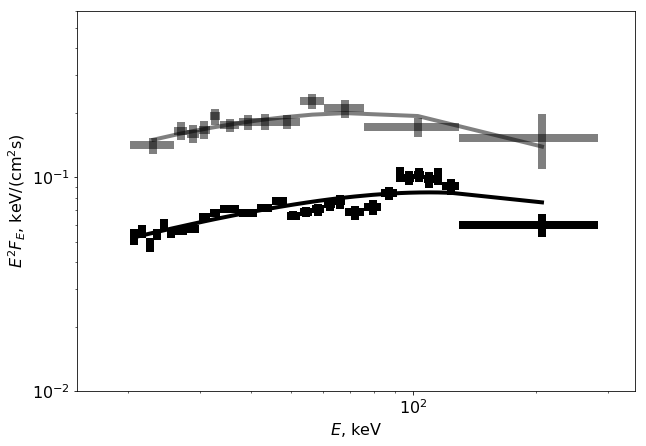

In [21]:
plt.figure(figsize=(10,7))

spectrum=np.genfromtxt(name+'_spectrum.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=1)
plt.plot(en,mo,color='black',linewidth=4)

spectrum=np.genfromtxt(name+'_flare_spectrum.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=0.5)
plt.plot(en,mo,color='black',linewidth=4,alpha=0.5)


plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-2,6.e-1)
plt.xlim(15,350)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.savefig(name+'_spectra.pdf',format='pdf',dpi=100)




In [22]:
spectrum_NGC2110=name+'_spectra.pdf'